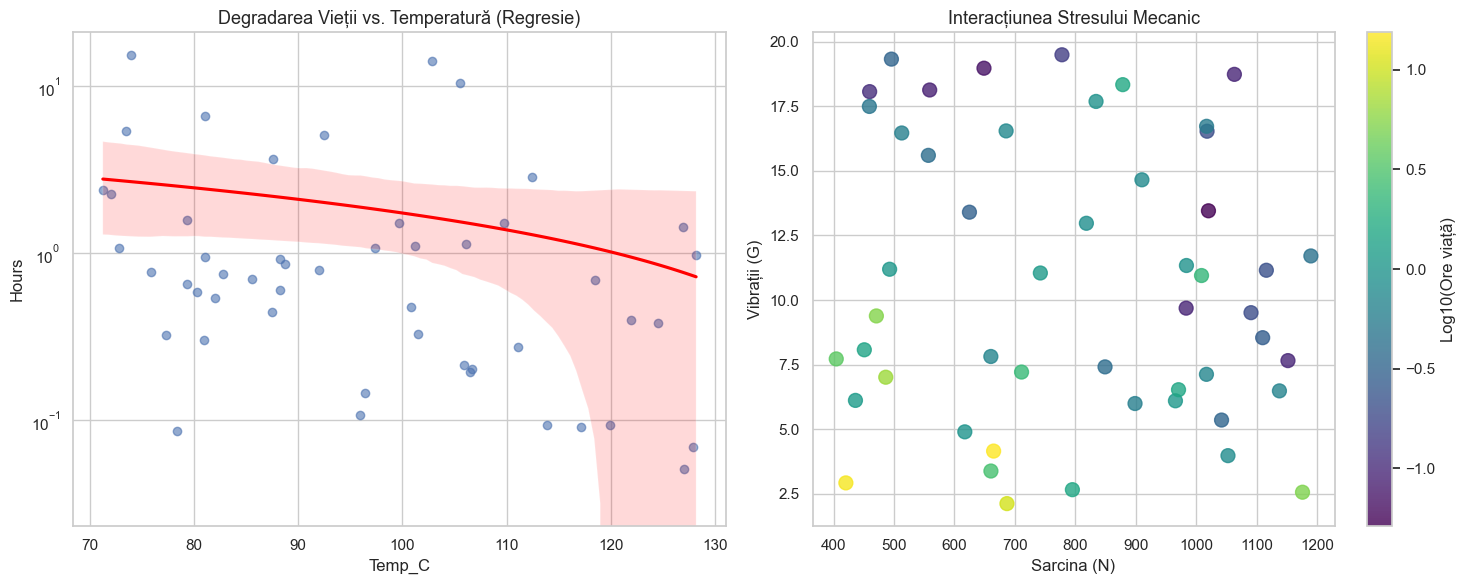

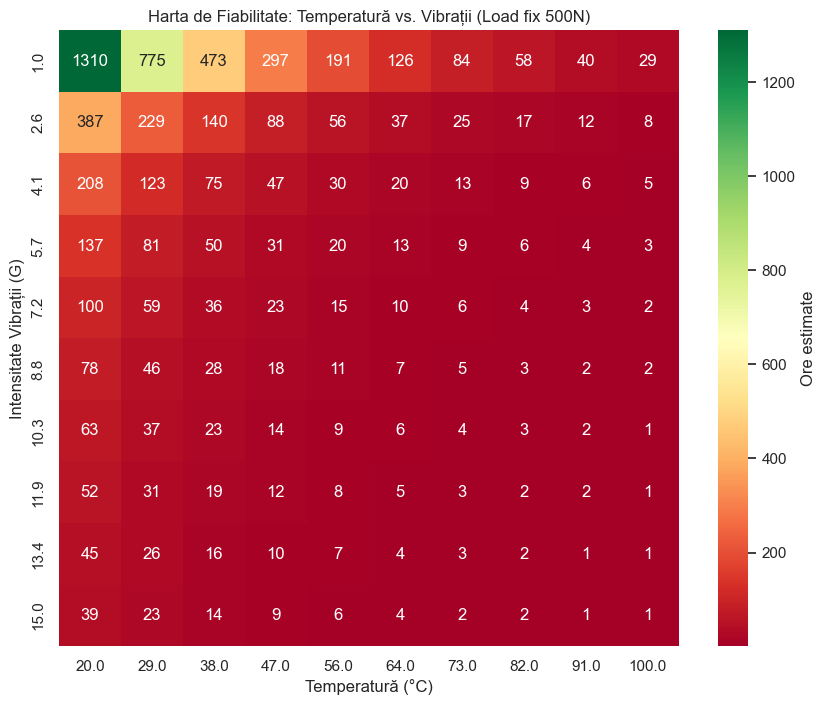

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Setăm stilul vizual Seaborn
sns.set_theme(style="whitegrid")

# 1. Definirea modelului (Arrhenius + Power Law)
def life_model(inputs, A, Ea, n, m):
    temp, load, vib = inputs
    k = 8.617e-5  # Boltzmann
    temp_k = temp + 273.15
    return A * np.exp(Ea / (k * temp_k)) * (load**-n) * (vib**-m)

# 2. Generare date sintetice (Accelerated Life Testing)
np.random.seed(42)
n_samples = 50
temp_test = np.random.uniform(70, 130, n_samples)
load_test = np.random.uniform(400, 1200, n_samples)
vib_test = np.random.uniform(2, 20, n_samples)

A_true, Ea_true, n_true, m_true = 0.5, 0.45, 1.6, 1.3
base_life = life_model((temp_test, load_test, vib_test), A_true, Ea_true, n_true, m_true)
failure_times = base_life * np.random.weibull(1.5, n_samples)

df_alt = pd.DataFrame({
    'Temp_C': temp_test,
    'Load_N': load_test,
    'Vib_G': vib_test,
    'Hours': failure_times
})

# 3. Vizualizarea corelațiilor cu Seaborn
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Graficul 1: Impactul Temperaturii (Scară logaritmică pe Y)
sns.regplot(ax=axes[0], x='Temp_C', y='Hours', data=df_alt, 
            logx=False, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
axes[0].set_yscale('log')
axes[0].set_title('Degradarea Vieții vs. Temperatură (Regresie)', fontsize=13)

# Graficul 2: Relația Sarcina vs. Vibrații colorată după Durata de Viață
scatter = axes[1].scatter(df_alt['Load_N'], df_alt['Vib_G'], 
                         c=np.log10(df_alt['Hours']), cmap='viridis', s=100, alpha=0.8)
fig.colorbar(scatter, ax=axes[1], label='Log10(Ore viață)')
axes[1].set_xlabel('Sarcina (N)')
axes[1].set_ylabel('Vibrații (G)')
axes[1].set_title('Interacțiunea Stresului Mecanic', fontsize=13)

plt.tight_layout()
plt.show()

# 4. Heatmap de Sensibilitate (Matrice de predicție)
# Creăm o grilă de temperaturi și vibrații pentru a vedea zonele critice
t_grid = np.linspace(20, 100, 10)
v_grid = np.linspace(1, 15, 10)
T, V = np.meshgrid(t_grid, v_grid)
# Calculăm viața estimată pentru un Load constant de 500N folosind parametrii estimați anterior
Z_life = life_model((T, 500, V), A_true, Ea_true, n_true, m_true)

plt.figure(figsize=(10, 8))
df_heatmap = pd.DataFrame(Z_life, index=np.round(v_grid, 1), columns=np.round(t_grid, 0))
sns.heatmap(df_heatmap, annot=True, fmt=".0f", cmap="RdYlGn", cbar_kws={'label': 'Ore estimate'})
plt.title('Harta de Fiabilitate: Temperatură vs. Vibrații (Load fix 500N)')
plt.xlabel('Temperatură (°C)')
plt.ylabel('Intensitate Vibrații (G)')
plt.show()

1. Parametrii de Accelerare (Inima Modelului)Energia de Activare ($E_a$):Ce reprezintă: Sensibilitatea produsului la stresul termic.Interpretare: O valoare tipică în electronică/mecanică este între 0.3 eV și 1.1 eV. Dacă $E_a$ calculat este mare (ex: peste 0.8 eV), înseamnă că temperatura este inamicul principal. O mică reducere a temperaturii de operare va prelungi drastic viața produsului.Exponenții de Sarcina ($n$) și Vibrații ($m$):Interpretare: Aceștia indică agresivitatea stresului mecanic. Dacă $n > 2$, avem o relație non-liniară severă: dublarea sarcinii nu reduce viața la jumătate, ci de 4 ori sau mai mult.2. Analiza Graficului de Regresie (Seaborn regplot)Panta Liniei: Cu cât linia de regresie este mai abruptă, cu atât produsul este mai instabil sub stres.Intervalul de Încredere (Zona umbrită):Dacă zona umbrită este îngustă, modelul tău este predictiv și te poți baza pe cifre.Dacă zona este largă, ai o variabilitate mare în procesul de fabricație sau eșantionul de test a fost prea mic.3. Interpretarea Hărții de Căldură (Heatmap)Acesta este instrumentul de "Safety Margin" (Marginea de Siguranță).Zonele Verzi (Valorile mari): Reprezintă regimul de funcționare optim. Dacă valorile sunt mult peste durata de viață garantată, produsul este "over-engineered" (prea scump pentru ce face).Zonele Roșii (Valorile mici): Indică punctul unde stresul combinat (ex: 90°C + 15G vibrații) anulează beneficiile designului.Punctul de Intersecție: Te ajută să decizi: "Dacă nu pot reduce vibrațiile în locația de instalare, cu câte grade trebuie să răcesc sistemul pentru a compensa?"4. Extrapolarea la Condiții NormaleCea mai importantă cifră este Durata de viață estimată la 25°C.Dacă testul accelerat a durat 500 ore la 120°C, iar modelul prezice 50,000 ore la 25°C, ai obținut un Factor de Accelerare (AF) de 100.Decizie de Business: Dacă 50,000 ore înseamnă ~5.7 ani și garanția oferită este de 2 ani, ești în zona de siguranță. Dacă estimarea este de sub 20,000 ore, riști falimentul prin costuri de service.